# Week 4 Async Code: Benefits of Blocking 

What are the benefits to blocking? Is it worth our time? 

Begin by loading the same set of data from last week's data. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [34]:
def make_data(tau=0):
    '''
    args: 
      tau: the size of the treatment effect. 
    this will make data for us to use. it will always make 20 men and 20 women. 
    '''
    df = pd.DataFrame({
        'group': np.repeat(a=['man', 'woman'], repeats=20)
        })
    
    df['po_control'] = np.concatenate([np.arange(1,21), np.arange(51,71)], 
        axis=None)
    df['po_treat'] = df['po_control'] + tau 

    return df 

In [4]:
df = make_data()
df.head()

,group,po_control,po_treat
0,man,1,1
1,man,2,2
2,man,3,3
3,man,4,4
4,man,5,5


As well, load the randomize function from last week. The only addition is that we're going to include a argument, `n`, for the number of instances that we're randomizing. 

In [5]:
def randomize(n): 
    urn = np.repeat([0,1], repeats=n)
    np.random.shuffle(urn)
    
    return urn

Finally, lets build a function that will permit us to block randomize. That is, to specify a total number of randomizations that are going to be run (called in `n`, as with `randomize`); but with a *guarantee* that the first `n/2` are completely randomized and the second `n/2` are also completely randomized. 

What is the benefit to this? Then, we can know that we'll have a **good** randomization in the first set; and a **good** randomization in the second set as well.

As we're applying it to our data -- we'll have an even split of men in treatment and control, as well as an even split of women in treatment and control. 

In [6]:
def block_randomize(n):
    '''
    This is an intentionally simple function. Because we've built the data so that
    the first 20 rows are always men, and the last 20 are always women, we can just 
    randomly shuffle two different lists and append one to the other.
    '''
    urn = np.repeat([0,1], repeats=(n/2))
    
    men_assignment = np.random.permutation(urn)
    women_assignment = np.random.permutation(urn)
    
    treat_assignment = np.append(men_assignment, women_assignment)

    return treat_assignment 

In [7]:
block_randomize(10)

array([1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1])

In [8]:
randomize(20)

array([0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0])

And so, in one instance of running the experiment, we might have a distribution of treatment and control that is distributed in the following way: 

In [9]:
df['treat'] = randomize(20)
pd.crosstab(df['group'], df['treat'])

treat,0,1
group,,
man,9,11
woman,11,9


In another instance of the experiment, we might have a distribution of treatmetn and control that is distributed differently. We can see this by simply overwriting the first treatment assignment that we ran. 

In [10]:
df['treat'] = randomize(20)
pd.crosstab(df['group'], df['treat'])

treat,0,1
group,,
man,10,10
woman,10,10


In these tables, we have one randomization that assigned 8 of the treatment conditions to men, and two randomizations that assigned 11 of the treatment conditions to men (and the converse to women in all cases). 

Maybe this is ok. But maybe not. Here are two possible reasons that this might not be ok: 

1. It could be the case that for some **non-design** reason, we have a strong preference or incentive to have exactly the same number of units with some property in the treatment and control conditions. 
2. It could be the case that we want to increase the precision with which we estimate $\tau$, and so having a randomization that has very few units of one class in a group is an undesirable outcome. 


Let's define our function to run the experiment and estimate the ATE: 

(ignore for a moment the `block_unblock` argument

In [29]:
def run_experiment(n, df, block_unblock ='unblocked'):
    '''
    n:  number of times to run the randomization inference
    df: the data frame with the experimental data
    block_unblock: a flag for whether to block randomize
      takes values: {'blocked', 'unblocked'}
    '''
    if block_unblock=='unblocked':
        df['treat'] = randomize(n)
    elif block_unblock=='blocked': 
        df['treat'] = block_randomize(n)
    
    df['Y'] = 0
    df.loc[df['treat']==0, 'Y'] = df.loc[df['treat']==0, 'po_control']
    df.loc[df['treat']==1, 'Y'] = df.loc[df['treat']==1, 'po_treat']
    
    return(df)

def estimate_ate(df): 
    res = df[['treat', 'Y']].groupby('treat').mean()
    ate = res.diff()['Y'][1]
    treated_women = df.loc[df['group'] == 'woman']['treat'].sum()
    
    return(ate, treated_women)

In [12]:
df = run_experiment(20, df, block_unblock='unblocked')
pd.crosstab(df.group, df.treat)

treat,0,1
group,,
man,11,9
woman,9,11


In [13]:
df = run_experiment(20, df, block_unblock = 'blocked')
pd.crosstab(df.group, df.treat)

treat,0,1
group,,
man,10,10
woman,10,10


In [14]:
ate, women = estimate_ate(df)
print("The ate is:", ate, "the number of women is:", women)

The ate is: 0.09999999999999432 the number of women is: 10


With each of these three functions built, we can run an experiment (which randomizes treatment assginment) and estimate an ate. 

In [21]:
res = [estimate_ate(run_experiment(20, df, 'unblocked')) for _ in range(100)]

In [22]:
res[:5]

[(-3.799999999999997, 9),
 (14.099999999999998, 13),
 (13.5, 12),
 (-9.599999999999998, 8),
 (-3.5, 9)]

In [23]:
ate_unblocked = [res[i][0] for i in range(len(res))]
women_unblocked = [res[i][1] for i in range(len(res))]

ate_df_unblocked = pd.DataFrame(
    {'ate':ate_unblocked, 
     'women': women_unblocked}
)

In [24]:
ate_df_unblocked.head()

,ate,women
0,-3.8,9
1,14.1,13
2,13.5,12
3,-9.6,8
4,-3.5,9


Text(0, 0.5, 'Average Treatment Effect')

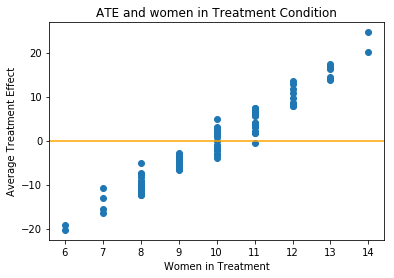

In [25]:
plt.scatter(women_unblocked, ate_unblocked)
plt.axhline(y=0, color = 'orange')
plt.title('ATE and women in Treatment Condition')
plt.xlabel('Women in Treatment')
plt.ylabel('Average Treatment Effect')

We set the study up so that we *know* there is no treatment effect. And, when we have 10 women who we randomize into control we, indeed, recover this absense of an effect. Our estimates for the ATE seem pretty well centered around zero. 

But, there is a clearly linear relationship between the number of women that we have enrolled and our estimated ATE. If, through our simple random assignment procedure we sampled 12 of twenty women to be in the treatment condition -- which is pretty likely -- we would estimate an ATE of about 10! 


# More blocking 

To address the problems of the last section, consider the following function called `block_randomize` that breaks the sample into two groups, *"blocks"*, and then performs the randomization within those groups. 


In [36]:
d = make_data(0)
d = run_experiment(20, df, 'blocked')
d.head()

,group,po_control,po_treat,treat,Y
0,man,1,1,1,1
1,man,2,2,1,2
2,man,3,3,0,3
3,man,4,4,1,4
4,man,5,5,0,5


Now that we've block randomized, we're *always* going to have the same number of units assigned to treatment as control *across the blocks that we've defined*. 

In [37]:
pd.crosstab(df['group'], df['treat'])

treat,0,1
group,,
man,10,10
woman,10,10


## Question of Understanding 

1. Recreate the plot that we had previously, this time using the block randomized data. What has changed? Why is this a useful change to have occurred? 
2. Does the restricted set of randomizations that we're realizing seem like "cheating"? Why or why not? 


## Re-run the last experiment with blocking

If we re-run the soy/estrogen experiment/observation from the last section, but we explicitly block on the number of men and women that we randomize into treatment and control arms, what happens? 

In [40]:
df = make_data(tau = 4)
df = run_experiment(20, df, block_unblock='blocked')


real_ate, real_women = estimate_ate(df)

In [41]:
f'The ate is {real_ate:.1f}, and the number of women is {real_women}.'

'The ate is 3.4, and the number of women is 10.'

In [45]:
N_RUNS = 1000

res   = [estimate_ate(run_experiment(20, df, 'blocked')) for _ in range(N_RUNS)]
ate   = [res[i][0] for i in range(N_RUNS)]
women = [res[i][1] for i in range(N_RUNS)]

res_u = [estimate_ate(run_experiment(20, df, 'unblocked')) for _ in range(N_RUNS)]
ate_u = [res_u[i][0] for i in range(N_RUNS)]
women_u = [res_u[i][1] for i in range(N_RUNS)]

Text(0, 0.5, 'Average Treatment Effect')

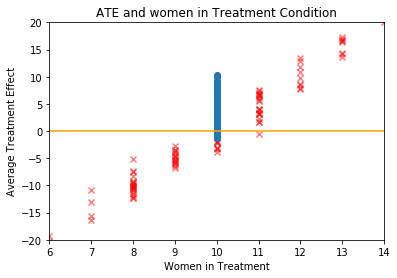

In [46]:
plt.scatter(women_unblocked, ate_unblocked, alpha=.5, c='red', marker='x')
plt.scatter(women, ate)
plt.xlim([6,14])
plt.ylim([-20, 20])
plt.axhline(y=0, color = 'orange')
plt.title('ATE and women in Treatment Condition')
plt.xlabel('Women in Treatment')
plt.ylabel('Average Treatment Effect')

What does the density of this distribution look like? In the plots below, the blue lines map the distribution of the blocked ATE, under the randomization inference loops. The orange lines are the **unblocked** ATE under the RI loops. 

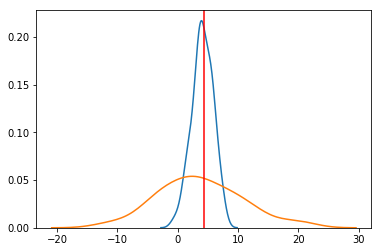

In [49]:
sns.kdeplot(ate)
sns.kdeplot(ate_u)
plt.axvline(x=real_ate, color = 'r')

Pull in the p-value from the last week and we can learn how the p-value generated changes when we block or don't block. 

# Question of Understanding 

1. At this point, what are we producing??? Are these randomization inference estimates? Or, something else? 

> 

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.





# Move on to Randomization Inference

As a small group: modify the code that we wrote last week to do the following: 

1. Include a new flag that turns *on* or *off* whether the randomization inference is going to re-randomize in a way that is *blocked* or that is *not blocked*. 
2. Run an experiment (using the code above) that *conducts* the experiment as though it is blocked, with a treatment effect of size 3. 
3. Conduct two sets of randomization inference: 
  1. One set that does *not* block randomize in the RI loops. 
  2. One set that *does* block randomize in the RI loops. 
4. How different, if at all, is what you learn through the two of these RI procedures?   

In [50]:
def p_value(measured_ate, ri_dist): 
    if np.sign(ate) == -1: 
        negative_vals = (ri_dist < measured_ate).astype('int').mean()
        positive_vals = (ri_dist > -1 * measured_ate).astype('int').mean()
    elif np.sign(ate) == 1: 
        negative_vals = (ri_dist < -1 * measured_ate).astype('int').mean()
        positive_vals = (ri_dist > measured_ate).astype('int').mean()
    pvalue = negative_vals + positive_vals
    
    return(pvalue)

When we **do** block, the p-value is: 

When we *do not* block, the p-value is: 

In [52]:
p_value(real_ate, ate_unblocked)

0.63

# Can we also do this with a regression?
Yep. 

In [47]:
# core stats package 
import statsmodels.formula.api as smf
# display of results 
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML


ModuleNotFoundError: No module named 'stargazer'

In [ ]:
df = make_data(tau = 5)
df = run_experiment(n=20, df=df, block_unblock='unblocked')
df.head()

In [ ]:
mod_1 = smf.ols(formula = 'Y ~ C(treat)', data = df).fit()
mod_2 = smf.ols(formula = 'Y ~ C(treat) + C(group)', data = df).fit()

In [ ]:
stargazer = Stargazer([mod_1, mod_2])

In [ ]:
HTML(stargazer.render_html())

That's some major improvement that we get for close to free! 